In [1]:
from remote_vgk import *

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
def load_password(path):

    with open(path) as f:
        secrets = json.load(f)
        shifted_pwd = secrets['password']
    pwd = ''
    for s in shifted_pwd:
        pwd += chr(ord(s) - 1)

    return pwd

In [3]:
try:
    window = gw.getWindowsWithTitle("millenicut:19")[0]
except IndexError:
    raise Exception("Window not found")

pwd = load_password('secrets.json')
sesh = DPO_Session('lwp26', pwd)

# Create the AirfoilApp
App = AirfoilApp(sesh.teaching_client, window)



C:\Users\louis\AppData\Local\Temp\ipykernel_61028\3745990620.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Angle of Attack [deg]')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


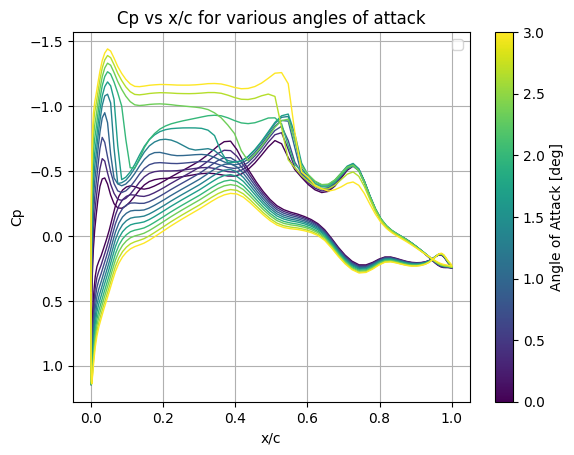

Session closed


In [4]:
nalph = 10
alphas = np.linspace(0, 4, nalph)
cs = plt.cm.viridis(np.linspace(0, 1, nalph))

plt.gca().invert_yaxis()
i = 0

for alpha in alphas:
    res = App.run(0.75, alpha)
    if res is None:
        continue

    plt.plot(res.x_upper, res.cp_upper, color=cs[i], linewidth = 1)
    plt.plot(res.x_lower, res.cp_lower, color=cs[i], linewidth = 1)

    i += 1

# add colourbar

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=alphas.min(), vmax=alphas.max()))
sm._A = []

plt.colorbar(sm, label='Angle of Attack [deg]')

plt.xlabel('x/c')
plt.ylabel('Cp')

plt.title('Cp vs x/c for various angles of attack')

plt.grid()
plt.legend()


plt.savefig('figures/cp_vs_xc_alphas.png')

In [5]:
#sesh.end()